<a href="https://colab.research.google.com/github/Vicente-Hernandez/motor-simulacion-ventas-akira/blob/main/motor_simulacion_ventas_akira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Configuración de Entorno y Dependencias**

In [28]:
import logging
import os

# Configurar un sistema de logging profesional para reemplazar los print()
# INFO: Mensajes generales de flujo.
# WARNING: Advertencias que no detienen el programa.
# ERROR: Errores que sí detienen una operación.
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - [%(levelname)s] - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

logging.info("Sistema de logging inicializado.")

# --- MANEJO DE DEPENDENCIAS ---
# En lugar de usar !pip install en el código, es una mejor práctica
# se crea un archivo llamado 'requirements.txt' con el siguiente contenido:
#
# openpyxl
# pandas
# numpy
# requests
#
# Luego, un profesional instalaría las dependencias con el comando: pip install -r requirements.txt

### **Configuración Centralizada**

In [29]:
# Imports
import pandas as pd
import numpy as np
import requests
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Union
from dataclasses import dataclass, field
import warnings
warnings.filterwarnings('ignore')

logging.info("Dependencias principales importadas.")

# ============================================================================
# CONFIGURACIÓN CENTRALIZADA
# ============================================================================

@dataclass
class SimulationConfig:
    """Configuración centralizada y reproducible del sistema de simulación."""

    # --- NUEVO: Para reproducibilidad ---
    random_seed: Optional[int] = 42
    rng: np.random.Generator = field(init=False, repr=False, compare=False)

    def __post_init__(self):
        """Inicializa el generador de números aleatorios después de crear la instancia."""
        self.rng = np.random.default_rng(self.random_seed)

    # Parámetros Generales
    prob_persona_juridica: float = 0.05
    valor_uf_aproximado: int = 37500

    # Distribuciones de Intención de Compra
    distribucion_intencion: Dict = field(default_factory=lambda: {
        'BUENO': {'nombres': ['Comprador Decidido', 'Vitrineador', 'Cliente de Renovación'], 'probs': [0.35, 0.30, 0.35]},
        'MALO': {'nombres': ['Comprador Decidido', 'Vitrineador', 'Cliente de Renovación'], 'probs': [0.30, 0.40, 0.30]},
        'NEUTRAL': {'nombres': ['Comprador Decidido', 'Vitrineador', 'Cliente de Renovación'], 'probs': [0.325, 0.35, 0.325]}
    })

    # --- AJUSTADO: Distribución de Tamaño de Empresas ---
    distribucion_empresa: Dict = field(default_factory=lambda: {
        'nombres': ['Micro', 'Pequeña', 'Mediana', 'Grande'],
        'probs': [0.05, 0.10, 0.45, 0.40]
    })

    # --- NUEVO: Probabilidad de pago al contado ---
    prob_pago_contado: Dict = field(default_factory=lambda: {
        'Solvente': 0.40, 'Consolidado': 0.50, 'Endeudado': 0.05,
        'Joven Profesional': 0.10, 'Aspiracional': 0.01, 'Empresa': 0.30
    })

    # Scoring de Afinidad
    ponderacion_perfil: float = 0.35
    ponderacion_precio: float = 0.30
    ponderacion_vehiculo_actual: float = 0.20

    # Parámetros de Financiamiento
    renta_minima_requerida: int = 600000
    antiguedad_laboral_minima: int = 1
    pie_maximo_porcentaje: float = 0.50
    rango_vrg_valido: Tuple[float, float] = (0.30, 0.40)

    prob_mal_dicom: Dict = field(default_factory=lambda: {
        'Solvente': 0.03, 'Endeudado': 0.25, 'Joven Profesional': 0.10,
        'Aspiracional': 0.35, 'Consolidado': 0.05, 'Empresa': 0.10
    })

    # --- AJUSTADO: Ratio de carga financiera ---
    ratio_carga_financiera: Dict = field(default_factory=lambda: {
        'Solvente': 0.30, 'Consolidado': 0.25, 'Joven Profesional': 0.30,
        'Endeudado': 0.30, 'Aspiracional': 0.35, 'Empresa': 0.30
    })

    prob_compra_post_aprobacion: Dict = field(default_factory=lambda: {
        'Comprador Decidido': 0.95, 'Cliente de Renovación': 0.90, 'Vitrineador': 0.60
    })

    estructura_tasas: Dict = field(default_factory=lambda: {
        'periodo_1': {'tasas_mercado': {0.0256: 0.15, 0.0199: 0.65, 0.0179: 0.20}}
    })

    prob_elegir_renovacion: Dict = field(default_factory=lambda: {
        'Solvente': 0.70, 'Endeudado': 0.80, 'Joven Profesional': 0.75,
        'Aspiracional': 0.85, 'Consolidado': 0.10, 'Empresa': 0.90
    })

    rango_pie_por_perfil: Dict = field(default_factory=lambda: {
        'Solvente': (0.35, 0.50), 'Endeudado': (0.25, 0.40),
        'Joven Profesional': (0.20, 0.35), 'Aspiracional': (0.20, 0.25),
        'Consolidado': (0.30, 0.50), 'Empresa': (0.20, 0.40)
    })

    # --- REFACTORIZADO: Plazos por perfil ---
    plazos_por_perfil: Dict = field(default_factory=lambda: {
        'Solvente': {'plazos': [36, 24, 48, 60], 'probs': [0.40, 0.30, 0.20, 0.10]},
        'Endeudado': {'plazos': [48, 36, 60], 'probs': [0.50, 0.30, 0.20]},
        'Joven Profesional': {'plazos': [36, 48, 24], 'probs': [0.50, 0.30, 0.20]},
        'Aspiracional': {'plazos': [48, 36], 'probs': [0.60, 0.40]},
        'Consolidado': {'plazos': [24, 36, 48, 60], 'probs': [0.50, 0.30, 0.15, 0.05]},
        'Empresa': {'plazos': [36, 24, 48], 'probs': [0.60, 0.30, 0.10]}
    })

    def validate(self) -> bool:
        """Valida la consistencia de la configuración."""
        try:
            for escenario, dist in self.distribucion_intencion.items():
                assert abs(sum(dist['probs']) - 1.0) < 0.01, f"Probs de intención en {escenario} no suman 1.0"
            assert abs(sum(self.distribucion_empresa['probs']) - 1.0) < 0.01, "Probs de tamaño empresa no suman 1.0"
            assert 0 <= self.prob_persona_juridica <= 1, "prob_persona_juridica debe estar entre 0 y 1"
            assert 0 < self.rango_vrg_valido[0] < self.rango_vrg_valido[1] < 1, "Rango VRG inválido"
            logging.info("Configuración validada correctamente.")
            return True
        except AssertionError as e:
            logging.error(f"Error en validación de configuración: {e}")
            return False

# Inicializar configuración global
CONFIG = SimulationConfig(random_seed=42) # Usamos una semilla fija para reproducibilidad
CONFIG.validate()
logging.info("Configuración global inicializada y validada.")

### **Generador de Perfiles**

In [30]:
"""
PILAR 1 - SISTEMA DE GENERACIÓN DE PERFILES DE CLIENTES
"""
try:
    from google.colab import userdata
    IS_COLAB = True
    logging.info("Entorno Colab detectado. Se usarán Colab Secrets para credenciales.")
except ImportError:
    IS_COLAB = False
    logging.info("Entorno no-Colab detectado. Se usarán variables de entorno para credenciales.")

class MacroeconomicContext:
    """Gestor de contexto macroeconómico desde API Banco Central de Chile."""

    BASE_URL = "https://si3.bcentral.cl/SieteRestWS/SieteRestWS.ashx"
    SERIES_CODIGOS = {'desempleo_tasa': 'F049.DES.TAS.INE.02.M'}

    def __init__(self):
        self.context_cache: Dict[str, Dict] = {}

    @staticmethod
    def _get_credentials() -> Tuple[str, str]:
        """Obtiene credenciales del BCCh de forma segura desde Colab Secrets o variables de entorno."""
        try:
            if IS_COLAB:
                usuario = userdata.get('BCCH_USER')
                clave = userdata.get('BCCH_PASS')
            else:
                usuario = os.getenv('BCCH_USER')
                clave = os.getenv('BCCH_PASS')

            if not usuario or not clave:
                raise ValueError("Credenciales BCCH_USER o BCCH_PASS no encontradas en el entorno.")
            return usuario, clave
        except Exception as e:
            raise ValueError(f"No se pudieron obtener credenciales del BCCh: {e}")

    def fetch_data(self, start_date: str, end_date: str) -> Optional[Dict[str, Dict]]:
        """Descarga datos macroeconómicos del período especificado."""
        try:
            usuario, clave = self._get_credentials()
            lista_dataframes = []

            for nombre_columna, codigo in self.SERIES_CODIGOS.items():
                params = {
                    'user': usuario, 'pass': clave, 'function': 'GetSeries',
                    'timeseries': codigo, 'firstdate': start_date, 'lastdate': end_date
                }
                response = requests.get(self.BASE_URL, params=params, timeout=30)
                response.raise_for_status()
                json_data = response.json().get('Series', {}).get('Obs', [])
                if not json_data:
                    continue

                df_serie = pd.DataFrame(json_data)[['indexDateString', 'value']]
                df_serie['indexDateString'] = pd.to_datetime(df_serie['indexDateString'], format='%d-%m-%Y')
                df_serie.rename(columns={'indexDateString': 'date', 'value': nombre_columna}, inplace=True)
                df_serie.set_index('date', inplace=True)
                df_serie[nombre_columna] = pd.to_numeric(df_serie[nombre_columna], errors='coerce')
                lista_dataframes.append(df_serie)

            if not lista_dataframes:
                raise ValueError("No se obtuvieron datos de la API del BCCh.")

            df_completo = pd.concat(lista_dataframes, axis=1)
            df_mensual = df_completo.resample('ME').agg({'desempleo_tasa': 'last'}).ffill().bfill()
            df_mensual['desempleo_tasa'] = df_mensual['desempleo_tasa'] / 100

            contexto = {
                index.strftime('%Y-%m'): {'desempleo_tasa': row['desempleo_tasa']}
                for index, row in df_mensual.iterrows()
            }

            self.context_cache = contexto
            logging.info(f"Datos macroeconómicos descargados: {len(contexto)} meses.")
            return contexto

        except Exception as e:
            logging.warning(f"Error al obtener datos de BCCh: {e}. Se usarán escenarios manuales.")
            return None

    @staticmethod
    def classify_scenario(data_mes: Dict) -> str:
        """Clasifica el escenario económico según indicadores."""
        tasa_desempleo = data_mes.get('desempleo_tasa', 0.08)
        if tasa_desempleo > 0.085:
            return 'MALO'
        elif tasa_desempleo < 0.07:
            return 'BUENO'
        else:
            return 'NEUTRAL'

class GeographicClassifier:
    """Clasificador de comunas según nivel socioeconómico."""
    CLASIFICACION_COMUNAS = {
        'ABC1_ALTO': ['VITACURA', 'LO BARNECHEA', 'LAS CONDES'],
        'ABC1_C2_ALTO': ['PROVIDENCIA', 'ÑUÑOA', 'LA REINA', 'HUECHURABA', 'PEÑALOLÉN'],
        'C2_MEDIO': ['MACUL', 'SAN MIGUEL', 'LA FLORIDA', 'QUINTA NORMAL', 'INDEPENDENCIA', 'SANTIAGO', 'ESTACIÓN CENTRAL', 'MAIPÚ', 'LA CISTERNA', 'SAN JOAQUÍN', 'PEDRO AGUIRRE CERDA'],
        'C3_MEDIO_BAJO': ['PUENTE ALTO', 'QUILICURA', 'RENCA', 'RECOLETA', 'CONCHALÍ', 'CERRILLOS', 'LO PRADO', 'PUDAHUEL', 'CERRO NAVIA', 'LA GRANJA', 'SAN RAMÓN', 'LA PINTANA', 'EL BOSQUE']
    }

    @classmethod
    def classify(cls, comuna: Optional[str]) -> str:
        """Clasifica una comuna en uno de los grupos GSE."""
        if pd.isna(comuna) or comuna is None:
            return 'DESCONOCIDA'
        if not isinstance(comuna, str):
            try:
                comuna = str(comuna)
            except Exception:
                return 'DESCONOCIDA'
        comuna_norm = comuna.upper().strip()
        for grupo, comunas_list in cls.CLASIFICACION_COMUNAS.items():
            if comuna_norm in comunas_list:
                return grupo
        return 'D_E_BAJO'

class ClientProfileGenerator:
    """Generador de perfiles sintéticos de clientes."""
    GSE_ARQUETIPOS = {'GSE_AB': (['Solvente'], [1.0]), 'GSE_C1a': (['Solvente', 'Endeudado'], [0.7, 0.3]), 'GSE_C1b': (['Endeudado', 'Joven Profesional'], [0.6, 0.4]), 'GSE_C2': (['Joven Profesional', 'Aspiracional', 'Endeudado'], [0.5, 0.3, 0.2]), 'GSE_C3': (['Aspiracional', 'Joven Profesional'], [0.7, 0.3]), 'GSE_D': (['Aspiracional'], [1.0]), 'GSE_E': (['Aspiracional'], [1.0])}
    ARQUETIPO_PARAMS = {'Solvente': {'rango_edad': (40, 70), 'rango_ingreso': (2500000, 9000000), 'rango_endeudamiento': (0.10, 0.25), 'prob_propiedad': 0.85, 'prob_vehiculo': 0.95}, 'Endeudado': {'rango_edad': (35, 55), 'rango_ingreso': (2000000, 7000000), 'rango_endeudamiento': (0.50, 0.75), 'prob_propiedad': 0.60, 'prob_vehiculo': 0.90}, 'Joven Profesional': {'rango_edad': (26, 38), 'rango_ingreso': (1200000, 2500000), 'rango_endeudamiento': (0.20, 0.40), 'prob_propiedad': 0.05, 'prob_vehiculo': 0.50}, 'Aspiracional': {'rango_edad': (30, 60), 'rango_ingreso': (800000, 1500000), 'rango_endeudamiento': (0.15, 0.35), 'prob_propiedad': 0.15, 'prob_vehiculo': 0.40}}
    EMPRESA_PARAMS = {'Micro': {'rango_empleados': (1, 10), 'rango_ventas_uf': (1, 2400), 'rango_ingreso_mensual': (500000, 3000000), 'prob_vehiculo': 0.10}, 'Pequeña': {'rango_empleados': (11, 50), 'rango_ventas_uf': (2401, 25000), 'rango_ingreso_mensual': (3000001, 15000000), 'prob_vehiculo': 0.40}, 'Mediana': {'rango_empleados': (51, 200), 'rango_ventas_uf': (25001, 100000), 'rango_ingreso_mensual': (15000001, 50000000), 'prob_vehiculo': 0.70}, 'Grande': {'rango_empleados': (201, 1000), 'rango_ventas_uf': (100001, 500000), 'rango_ingreso_mensual': (50000001, 200000000), 'prob_vehiculo': 0.95}}

    def __init__(self, df_gse: pd.DataFrame, df_mercado: pd.DataFrame, config: SimulationConfig):
        self.df_gse = df_gse
        self.df_mercado = df_mercado
        self.config = config
        self.df_otras_marcas = df_mercado[df_mercado['marca'] != 'Akira Motors'].copy()
        if not self.df_otras_marcas.empty:
            self.df_otras_marcas['market_share'] /= self.df_otras_marcas['market_share'].sum()

    def _obtener_arquetipo_desde_gse(self, gse_cliente: str) -> str:
        opciones, probs = self.GSE_ARQUETIPOS.get(gse_cliente, (['Aspiracional'], [1.0]))
        return self.config.rng.choice(opciones, p=probs)

    def _generar_vehiculo_actual(self, tiene_vehiculo: bool, arquetipo: str) -> Tuple[Optional[str], Optional[str]]:
        if not tiene_vehiculo: return None, None
        prob_akira = 0.15 if arquetipo in ['Solvente', 'Endeudado'] else 0.05
        if self.config.rng.random() < prob_akira:
            return 'Akira Motors', 'Akira Motors Chile (Filial)'
        else:
            if self.df_otras_marcas.empty: return None, None
            marca_sorteada = self.df_otras_marcas.sample(n=1, weights='market_share', random_state=self.config.rng).iloc[0]
            return marca_sorteada['marca'], marca_sorteada['grupo']

    def generar_persona_natural(self) -> Dict:
        if self.df_gse is None or self.df_gse.empty: raise ValueError("DataFrame GSE no disponible")
        comuna_seleccionada = self.df_gse.sample(n=1, random_state=self.config.rng).iloc[0]
        gse_cols = ['GSE_AB', 'GSE_C1a', 'GSE_C1b', 'GSE_C2', 'GSE_C3', 'GSE_D', 'GSE_E']
        gse_cliente = self.config.rng.choice(gse_cols, p=comuna_seleccionada[gse_cols].astype(float))
        arquetipo = self._obtener_arquetipo_desde_gse(gse_cliente)
        params = self.ARQUETIPO_PARAMS[arquetipo]
        edad = self.config.rng.integers(params['rango_edad'][0], params['rango_edad'][1] + 1)
        ingreso_bruto = self.config.rng.integers(params['rango_ingreso'][0], params['rango_ingreso'][1] + 1)
        ingreso_mensual = int(round(ingreso_bruto / 1000)) * 1000
        nivel_endeudamiento = round(self.config.rng.uniform(params['rango_endeudamiento'][0], params['rango_endeudamiento'][1]), 2)
        tiene_propiedad = self.config.rng.random() < params['prob_propiedad']
        tiene_vehiculo = self.config.rng.random() < params['prob_vehiculo']
        marca_vehiculo, grupo_vehiculo = self._generar_vehiculo_actual(tiene_vehiculo, arquetipo)
        return {'comuna': comuna_seleccionada['Comuna'], 'gse': gse_cliente, 'tipo_cliente': 'Persona Natural', 'perfil_financiero': arquetipo, 'edad': edad, 'ingreso_mensual': ingreso_mensual, 'nivel_endeudamiento': nivel_endeudamiento, 'tiene_propiedad': tiene_propiedad, 'tiene_vehiculo': tiene_vehiculo, 'marca_vehiculo_actual': marca_vehiculo, 'grupo_vehiculo_actual': grupo_vehiculo}

    def generar_persona_juridica(self) -> Dict:
        tamaño_empresa = self.config.rng.choice(self.config.distribucion_empresa['nombres'], p=self.config.distribucion_empresa['probs'])
        params = self.EMPRESA_PARAMS[tamaño_empresa]
        num_empleados = self.config.rng.integers(params['rango_empleados'][0], params['rango_empleados'][1] + 1)
        ventas_anuales_uf = round(self.config.rng.uniform(params['rango_ventas_uf'][0], params['rango_ventas_uf'][1]), 2)
        ingreso_mensual_clp = self.config.rng.integers(params['rango_ingreso_mensual'][0], params['rango_ingreso_mensual'][1] + 1)
        tiene_vehiculo = self.config.rng.random() < params['prob_vehiculo']
        marca_vehiculo, grupo_vehiculo = self._generar_vehiculo_actual(tiene_vehiculo, 'Empresa')
        comuna_asignada = self.config.rng.choice(['Santiago', 'Providencia', 'Las Condes'])
        return {'tipo_cliente': 'Persona Jurídica', 'clasificacion_empresa': tamaño_empresa, 'numero_empleados': num_empleados, 'ventas_anuales_uf': ventas_anuales_uf, 'ingreso_mensual_clp': ingreso_mensual_clp, 'tiene_vehiculo': tiene_vehiculo, 'marca_vehiculo_actual': marca_vehiculo, 'grupo_vehiculo_actual': grupo_vehiculo, 'comuna': comuna_asignada}

    def generar_lead_completo(self, escenario_economico: str, fecha_simulada: str) -> Dict:
        """Genera un lead completo con todos sus atributos, asegurando la lógica correcta."""
        es_juridica = self.config.rng.random() < self.config.prob_persona_juridica
        perfil_base = self.generar_persona_juridica() if es_juridica else self.generar_persona_natural()

        # 1. Asignar intención y añadirla al perfil
        dist = self.config.distribucion_intencion.get(escenario_economico, self.config.distribucion_intencion['NEUTRAL'])
        intencion = self.config.rng.choice(dist['nombres'], p=dist['probs'])
        perfil_base['intencion'] = intencion

        # 2. Asignar preferencia de pago y añadirla al perfil
        perfil_cliente = perfil_base.get('perfil_financiero') or 'Empresa'
        prob_contado = self.config.prob_pago_contado.get(perfil_cliente, 0.05)
        perfil_base['preferencia_pago'] = 'Contado' if self.config.rng.random() < prob_contado else 'Financiamiento'

        # 3. Calcular el score con el perfil_base ya completo
        score_info = self._calcular_lead_score(perfil_base)

        # 4. Consolidar perfil final
        perfil_final = {**perfil_base, 'fecha_simulada': fecha_simulada, 'escenario_macro': escenario_economico, **score_info}
        return perfil_final

    @staticmethod
    def _calcular_lead_score(perfil: Dict) -> Dict:
        """Calcula el score de calificación del lead."""
        score = 0
        if perfil.get('tipo_cliente') == 'Persona Natural':
            map_financiero = {'Solvente': 50, 'Endeudado': 25, 'Joven Profesional': 35, 'Aspiracional': 10}
            score += map_financiero.get(perfil.get('perfil_financiero'), 0)
        else:
            map_empresa = {'Grande': 50, 'Mediana': 40, 'Pequeña': 25, 'Micro': 10}
            score += map_empresa.get(perfil.get('clasificacion_empresa'), 0)

        map_intencion = {'Comprador Decidido': 50, 'Cliente de Renovación': 40, 'Vitrineador': 5}
        score += map_intencion.get(perfil.get('intencion'), 0)

        if score > 80: categoria = 'Hot'
        elif score > 50: categoria = 'Warm'
        else: categoria = 'Cold'

        return {'lead_score': score, 'lead_categoria': categoria}

logging.info("Pilar 1 (Generación de perfiles) cargado y corregido.")

### **Mercado y Catálogo**

In [31]:
"""
PILAR 2 - MERCADO AUTOMOTOR Y CATÁLOGO DE PRODUCTOS
"""
class AutomotiveMarket:
    """Gestor del mercado automotor chileno."""
    @staticmethod
    def create_market_dataframe() -> pd.DataFrame:
        """Crea DataFrame del mercado automotor con distribución de marcas."""
        data_mercado = {
            'marca': [
                'Suzuki', 'Changan', 'Mazda', 'Renault', 'Subaru', 'DFSK',
                'Mitsubishi', 'Chery', 'BYD', 'Jeep', 'GAC', 'Hyundai',
                'Toyota', 'Kia', 'Maxus', 'Jetour', 'Karry', 'Peugeot',
                'Opel', 'Akira Motors'
            ],
            'grupo': [
                'Inchcape', 'Inchcape', 'Inchcape', 'Inchcape', 'Inchcape', 'Inchcape',
                'Astara', 'Astara', 'Astara', 'Astara', 'Astara',
                'Gildemeister', 'Toyota Chile', 'Indumotora',
                'Kaufmann', 'Kaufmann', 'Karry', 'Peugeot', 'Opel',
                'Akira Motors Chile (Filial)'
            ],
            'market_share_base': [
                0.080, 0.045, 0.035, 0.030, 0.020, 0.015,
                0.036, 0.030, 0.015, 0.012, 0.010,
                0.067, 0.078, 0.063, 0.028, 0.015, 0.010,
                0.040, 0.015, 0.050
            ]
        }
        df = pd.DataFrame(data_mercado)
        df['market_share'] = df['market_share_base'] / df['market_share_base'].sum()
        return df

    @staticmethod
    def create_other_brands_dataframe(df_mercado: pd.DataFrame) -> pd.DataFrame:
        """Crea DataFrame de marcas competidoras (sin Akira)."""
        df_otras = df_mercado[df_mercado['marca'] != 'Akira Motors'].copy()
        if not df_otras.empty:
            df_otras['market_share'] = df_otras['market_share'] / df_otras['market_share'].sum()
        return df_otras


class VehicleCatalog:
    """Gestor del catálogo de vehículos Akira Motors."""
    PRECIOS_2024 = {
        'Yari SEDAN EXL': {'PRECIO_LISTA': 19490000, 'BONO': 500000}, 'Yari HATCHBACK': {'PRECIO_LISTA': 19490000, 'BONO': 500000},
        'Ronin EXT 1.5 TURBO': {'PRECIO_LISTA': 26390000, 'BONO': 1000000}, 'Ronin TOURING 1.5': {'PRECIO_LISTA': 30390000, 'BONO': 1000000},
        'Tanto LX 1.5 MECANICO': {'PRECIO_LISTA': 13490000, 'BONO': 1000000}, 'Tanto LX 1.5 MECANICO SMART': {'PRECIO_LISTA': 13990000, 'BONO': 1000000},
        'Tanto LX 1.5 AUT': {'PRECIO_LISTA': 16890000, 'BONO': 1300000}, 'Tanto EX 1.5 AUT': {'PRECIO_LISTA': 18190000, 'BONO': 1500000},
        'Tanto EX 1.5 AUT SMART': {'PRECIO_LISTA': 18590000, 'BONO': 1434000}, 'Tanto EXL 1.5 AUT': {'PRECIO_LISTA': 18990000, 'BONO': 1500000},
        'Tanto EXL 1.5 AUT SMART': {'PRECIO_LISTA': 42396000, 'BONO': 2423000}, 'Kunoichi LX 1.5 AUT.': {'PRECIO_LISTA': 21990000, 'BONO': 1000000},
        'Kunoichi EX 1.5 AUT': {'PRECIO_LISTA': 24490000, 'BONO': 500000}, 'Kunoichi EXL 1.5 AUT': {'PRECIO_LISTA': 26490000, 'BONO': 500000},
        'Katana EXT 1.5 TURBO': {'PRECIO_LISTA': 34990000, 'BONO': 500000}, 'Katana TOURING 1.5 4X4': {'PRECIO_LISTA': 39990000, 'BONO': 500000},
        'Hayabusa EXL 2.0 AUT': {'PRECIO_LISTA': 30990000, 'BONO': 500000}, 'Hayabusa TOURING 2.0 4X2': {'PRECIO_LISTA': 32490000, 'BONO': 500000},
        'Shogun TOURING 3.5': {'PRECIO_LISTA': 55990000, 'BONO': 1000000}, 'Shogun ELITE 3.5': {'PRECIO_LISTA': 57990000, 'BONO': 1000000},
        'Sumo RTL 3.5': {'PRECIO_LISTA': 53538100, 'BONO': 1190000}
    }
    PRECIOS_2025 = {
        'Yari SEDAN EXL': {'PRECIO_LISTA': 17990000, 'BONO': 1000000}, 'Ronin TOURING 1.5': {'PRECIO_LISTA': 30390000, 'BONO': 2000000},
        'Tanto LX 1.5 AUT': {'PRECIO_LISTA': 16990000, 'BONO': 2000000}, 'Tanto EX 1.5 AUT': {'PRECIO_LISTA': 18490000, 'BONO': 2500000},
        'Tanto EX 1.5 AUT SMART': {'PRECIO_LISTA': 19290000, 'BONO': 2500000}, 'Tanto EXL 1.5 AUT': {'PRECIO_LISTA': 19490000, 'BONO': 2500000},
        'Tanto EXL 1.5 AUT SMART': {'PRECIO_LISTA': 20290000, 'BONO': 2500000}, 'Kunoichi LX 1.5 AUT.': {'PRECIO_LISTA': 23990000, 'BONO': 2000000},
        'Kunoichi EX 1.5 AUT': {'PRECIO_LISTA': 24990000, 'BONO': 1000000}, 'Kunoichi EXL 1.5 AUT': {'PRECIO_LISTA': 26490000, 'BONO': 500000},
        'Katana TOURING 1.5 4X4': {'PRECIO_LISTA': 40990000, 'BONO': 2000000}, 'Katana ADVANCE HYBRID Aut. 4X4': {'PRECIO_LISTA': 48990000, 'BONO': 2000000},
        'Hayabusa EXL 2.0 AUT': {'PRECIO_LISTA': 30490000, 'BONO': 1500000}, 'Hayabusa TOURING 2.0 4X2': {'PRECIO_LISTA': 32490000, 'BONO': 1500000},
        'Shogun TOURING 3.5': {'PRECIO_LISTA': 57990000, 'BONO': 1000000}, 'Shogun ELITE 3.5': {'PRECIO_LISTA': 59990000, 'BONO': 1000000}
    }
    SEGMENTOS = {'Yari': 'Sedán/Hatchback', 'Ronin': 'Sedán', 'Tanto': 'Crossover SUV', 'Kunoichi': 'Crossover SUV', 'Katana': 'SUV', 'Hayabusa': 'Crossover SUV', 'Shogun': 'SUV Grande', 'Sumo': 'Camioneta'}

    @classmethod
    def create_catalog_dataframe(cls) -> pd.DataFrame:
        """Crea DataFrame del catálogo completo de vehículos."""
        lista_vehiculos = []
        for anio, precios_dict in [(2024, cls.PRECIOS_2024), (2025, cls.PRECIOS_2025)]:
            for version_completa, data in precios_dict.items():
                partes = version_completa.split(' ', 1)
                modelo = partes[0]
                version = partes[1] if len(partes) > 1 else ''
                lista_vehiculos.append({'año': anio, 'modelo': modelo, 'version': version, 'segmento': cls.SEGMENTOS.get(modelo, 'Otro'), 'precio_lista_clp': data['PRECIO_LISTA'], 'bono_financiamiento_clp': data['BONO']})
        return pd.DataFrame(lista_vehiculos)


class CommercialStructure:
    """Gestor de la estructura comercial (sucursales y vendedores)."""
    SUCURSALES = {
        'AK - Bilbao': {'comuna': 'La Reina', 'vendedores': ['Rodrigo Vidal', 'Andres Tobar']},
        'SAI - La Dehesa': {'comuna': 'Lo Barnechea', 'vendedores': ['Ricardo Valenzuela', 'Camila Torres']},
        'SAI - Las Condes': {'comuna': 'Las Condes', 'vendedores': ['Marcelo Carvallo', 'Anais Urdaneta']},
        'SAI - Movicenter': {'comuna': 'Huechuraba', 'vendedores': ['Adolfo Bravo', 'Debora Avila', 'Jesus Castillo']},
        'SAI - La Florida': {'comuna': 'La Florida', 'vendedores': ['Monica Fuentes', 'Felipe Gutierrez']},
        'SAI - Costanera': {'comuna': 'Providencia', 'vendedores': ['Daniel Lopez', 'Carolina Saavedra']},
        'SAI - Plaza Oeste': {'comuna': 'Cerrillos', 'vendedores': ['Esteban Paillao', 'Patricia Ramirez']},
        'V&D - Padre Hurtado': {'comuna': 'Las Condes', 'vendedores': ['Alejandra Paillamilla', 'Tatiana Jarusauskas']},
        'V&D - Manuel Montt': {'comuna': 'Providencia', 'vendedores': ['Angel Ramos', 'Daniela Morales']},
        'V&D - Irarrazaval': {'comuna': 'Nunoa', 'vendedores': ['Cesar Hernandez', 'Antonio Bustamante']}
    }
    PROB_VOLUMEN_BASE = {'SAI - Plaza Oeste': 0.16, 'SAI - Movicenter': 0.16, 'V&D - Manuel Montt': 0.16, 'AK - Bilbao': 0.11, 'V&D - Padre Hurtado': 0.11, 'SAI - La Dehesa': 0.06, 'SAI - Las Condes': 0.06, 'SAI - La Florida': 0.06, 'SAI - Costanera': 0.06, 'V&D - Irarrazaval': 0.06}

    @classmethod
    def get_normalized_probabilities(cls) -> Dict[str, float]:
        """Retorna probabilidades normalizadas de volumen por sucursal."""
        total = sum(cls.PROB_VOLUMEN_BASE.values())
        return {k: v / total for k, v in cls.PROB_VOLUMEN_BASE.items()}

# ============================================================================
# INICIALIZACIÓN DEL PILAR
# ============================================================================
df_mercado = AutomotiveMarket.create_market_dataframe()
df_otras_marcas = AutomotiveMarket.create_other_brands_dataframe(df_mercado)
df_catalogo_akira = VehicleCatalog.create_catalog_dataframe()
estructura_comercial = CommercialStructure.SUCURSALES
prob_volumen_sucursal = CommercialStructure.get_normalized_probabilities()

logging.info("Pilar 2 (Mercado y Catálogo) cargado correctamente.")
logging.info(f"- {len(df_mercado)} marcas en el mercado.")
logging.info(f"- {len(df_catalogo_akira)} versiones en catálogo Akira Motors.")
logging.info(f"- {len(estructura_comercial)} sucursales configuradas.")

### **Motor de Afinidad**

In [32]:
"""
PILAR 3 - MOTOR DE AFINIDAD CLIENTE-VEHÍCULO
"""
class PriceAffinityEngine:
    """Calcula compatibilidad de precio basado en perfil del cliente."""

    # --- AJUSTADO: Multiplicadores de ingreso ---
    MULTIPLICADORES = {
        'Solvente': 16,
        'Endeudado': 12,
        'Joven Profesional': 15,
        'Aspiracional': 14,
        'Grande': 24,
        'Mediana': 20,
        'Pequeña': 16,
        'Micro': 12
    }
    FLEXIBILIDAD = {
        'Solvente': 0.30, 'Endeudado': 0.15, 'Joven Profesional': 0.20,
        'Aspiracional': 0.20, 'Grande': 0.40, 'Mediana': 0.30,
        'Pequeña': 0.25, 'Micro': 0.20
    }

    @classmethod
    def calculate_score(cls, lead: Dict, precio_vehiculo: int) -> float:
        """Calcula score de compatibilidad precio-cliente."""
        ingreso = lead.get('ingreso_mensual_clp') if pd.notna(lead.get('ingreso_mensual_clp')) else lead.get('ingreso_mensual', 0)
        if not ingreso or ingreso <= 0:
            return 10.0

        perfil = lead.get('perfil_financiero') or lead.get('clasificacion_empresa', 'Pequeña')
        multiplicador = cls.MULTIPLICADORES.get(perfil, 14)
        flexibilidad = cls.FLEXIBILIDAD.get(perfil, 0.20)

        precio_ideal = ingreso * multiplicador
        desviacion_maxima = precio_ideal * flexibilidad
        diferencia = abs(precio_vehiculo - precio_ideal)

        if diferencia < desviacion_maxima:
            score = 100 * (1 - (diferencia / desviacion_maxima))
            return max(10.0, score)
        else:
            return 10.0

class GeographicAffinityAdjuster:
    """Ajusta afinidad vehicular según GSE de la comuna."""
    AJUSTES_GSE = {
        'ABC1_ALTO': {'Shogun': 1.45, 'Hayabusa': 1.35, 'Ronin': 1.25, 'Katana': 1.20, 'Kunoichi': 0.60, 'Tanto': 0.30, 'Yari': 0.40, 'Sumo': 1.00},
        'ABC1_C2_ALTO': {'Katana': 1.30, 'Hayabusa': 1.25, 'Kunoichi': 1.20, 'Ronin': 1.15, 'Shogun': 1.00, 'Tanto': 0.70, 'Yari': 0.80, 'Sumo': 0.80},
        'C2_MEDIO': {'Kunoichi': 1.35, 'Tanto': 1.20, 'Katana': 1.15, 'Yari': 1.15, 'Ronin': 1.00, 'Hayabusa': 0.60, 'Shogun': 0.50, 'Sumo': 0.40},
        'C3_MEDIO_BAJO': {'Tanto': 1.40, 'Yari': 1.35, 'Kunoichi': 1.20, 'Katana': 0.50, 'Ronin': 0.40, 'Hayabusa': 0.35, 'Shogun': 0.30, 'Sumo': 0.25},
        'D_E_BAJO': {'Tanto': 1.15, 'Yari': 1.10, 'Kunoichi': 0.20, 'Katana': 0.15, 'Ronin': 0.10, 'Hayabusa': 0.10, 'Shogun': 0.10, 'Sumo': 0.05},
        'DESCONOCIDA': {'Tanto': 1.00, 'Yari': 1.00, 'Kunoichi': 1.00, 'Katana': 1.00, 'Ronin': 1.00, 'Hayabusa': 1.00, 'Shogun': 1.00, 'Sumo': 1.00}
    }

    @classmethod
    def get_adjustment_factor(cls, modelo: str, comuna: str) -> float:
        """Obtiene factor de ajuste para un modelo en una comuna."""
        grupo_gse = GeographicClassifier.classify(comuna)
        ajustes = cls.AJUSTES_GSE.get(grupo_gse, cls.AJUSTES_GSE['DESCONOCIDA'])
        return ajustes.get(modelo, 1.0)

class VehicleAffinityEngine:
    """Motor principal de afinidad cliente-vehículo."""
    MODELO_PREMIUM_SCORE = {'Shogun': 100, 'Sumo': 95, 'Hayabusa': 90, 'Katana': 80, 'Ronin': 75, 'Kunoichi': 65, 'Tanto': 50, 'Yari': 45}

    def __init__(self, config: SimulationConfig):
        self.config = config

    def calculate_vehicle_affinity(self, lead: Dict, vehiculo: Dict) -> float:
        """Calcula el score de afinidad para un vehículo específico."""
        score_perfil = self.MODELO_PREMIUM_SCORE.get(vehiculo['modelo'], 50)
        score_precio = PriceAffinityEngine.calculate_score(lead, vehiculo['precio_lista_clp'])
        score_vehiculo_actual = 90 if lead.get('marca_vehiculo_actual') == 'Akira Motors' else 50

        puntaje_ponderado = (
            (score_perfil * self.config.ponderacion_perfil) +
            (score_precio * self.config.ponderacion_precio) +
            (score_vehiculo_actual * self.config.ponderacion_vehiculo_actual)
        )

        factor_comuna = GeographicAffinityAdjuster.get_adjustment_factor(vehiculo['modelo'], lead.get('comuna'))

        puntaje_ajustado = (
            puntaje_ponderado * factor_comuna * self.config.rng.uniform(0.95, 1.05)
        )

        return round(puntaje_ajustado, 2)

    def generate_vehicle_ranking(self, lead: Dict, catalogo: pd.DataFrame) -> pd.DataFrame:
        """Genera ranking de los 3 vehículos más afines para un lead."""
        try:
            anio_lead = int(lead['fecha_simulada'][:4])
            catalogo_filtrado = catalogo[catalogo['año'] == anio_lead].copy()
            if catalogo_filtrado.empty:
                catalogo_filtrado = catalogo.copy()
        except (TypeError, ValueError, KeyError):
            catalogo_filtrado = catalogo.copy()

        resultados = []
        for _, vehiculo in catalogo_filtrado.iterrows():
            vehiculo_dict = vehiculo.to_dict()
            score = self.calculate_vehicle_affinity(lead, vehiculo_dict)
            resultados.append({
                'modelo': vehiculo['modelo'], 'version': vehiculo['version'],
                'precio_lista_clp': vehiculo['precio_lista_clp'],
                'bono_financiamiento_clp': vehiculo['bono_financiamiento_clp'],
                'score': score
            })

        df_ranking = pd.DataFrame(resultados)
        return df_ranking.sort_values(by='score', ascending=False).head(3)

logging.info("Pilar 3 (Motor de afinidad) cargado y ajustado.")

### **Motor de Financiamiento**

In [33]:
"""
PILAR 4 - MOTOR DE FINANCIAMIENTO Y DECISIÓN DE COMPRA
"""
class FinancialCalculator:
    """Calculadora de productos financieros automotrices."""

    @staticmethod
    def calcular_cuota_mensual(
        monto: float,
        tasa_mensual: float,
        plazo_meses: int
    ) -> float:
        """
        Calcula cuota mensual usando amortización francesa.

        Args:
            monto: Monto a financiar en CLP
            tasa_mensual: Tasa de interés mensual (decimal)
            plazo_meses: Plazo en meses

        Returns:
            Cuota mensual en CLP
        """
        # Validaciones
        if monto <= 0:
            raise ValueError(f"Monto debe ser positivo: {monto}")
        if tasa_mensual <= 0 or tasa_mensual > 0.10:
            raise ValueError(f"Tasa mensual inválida: {tasa_mensual}")
        if plazo_meses <= 0 or plazo_meses > 84:
            raise ValueError(f"Plazo inválido: {plazo_meses}")

        # Fórmula de amortización francesa
        factor = (tasa_mensual * (1 + tasa_mensual)**plazo_meses) / \
                 ((1 + tasa_mensual)**plazo_meses - 1)

        return monto * factor

    @staticmethod
    def calcular_vrg(precio_lista: float, pie: float, monto_financiado: float) -> float:
        """Calcula el Valor Residual Garantizado (VRG)."""
        vrg = precio_lista - pie - monto_financiado
        return max(0, vrg)

class CreditEvaluator:
    """Evaluador de elegibilidad crediticia."""
    def __init__(self, config: SimulationConfig):
        self.config = config

    def evaluar_dicom(self, lead: Dict) -> bool:
        perfil = lead.get('perfil_financiero') or 'Empresa'
        prob_mal_dicom = self.config.prob_mal_dicom.get(perfil, 0.30)
        return self.config.rng.random() > prob_mal_dicom # Usa rng

    def get_parametros_financiamiento(self, lead: Dict) -> Tuple[int, Tuple[float, float]]:
        perfil = lead.get('perfil_financiero') or 'Empresa'
        plazos_dist = self.config.plazos_por_perfil.get(perfil, self.config.plazos_por_perfil['Aspiracional'])
        plazo = self.config.rng.choice(plazos_dist['plazos'], p=plazos_dist['probs']) # Usa rng
        rango_pie = self.config.rango_pie_por_perfil.get(perfil, (0.20, 0.30))
        return plazo, rango_pie

# ============================================================================
# EVALUADOR CREDITICIO
# ============================================================================

class CreditEvaluator:
    """Evaluador de elegibilidad crediticia."""

    def __init__(self, config: SimulationConfig):
        self.config = config

    def evaluar_dicom(self, lead: Dict) -> bool:
        """
        Evalúa si el lead tiene buenos antecedentes crediticios.

        Args:
            lead: Diccionario con datos del lead

        Returns:
            True si tiene buenos antecedentes, False si está en DICOM
        """
        perfil = lead.get('perfil_financiero') or 'Empresa'
        prob_mal_dicom = self.config.prob_mal_dicom.get(perfil, 0.30)

        # True = Buenos antecedentes, False = Mal DICOM
        return np.random.rand() > prob_mal_dicom

    def get_carga_financiera_maxima(self, lead: Dict) -> float:
        """
        Obtiene el ratio máximo de carga financiera según perfil.

        Args:
            lead: Diccionario con datos del lead

        Returns:
            Ratio máximo (ej: 0.25 = 25% del ingreso)
        """
        perfil = lead.get('perfil_financiero') or 'Empresa'
        return self.config.ratio_carga_financiera.get(perfil, 0.30)

    def get_parametros_financiamiento(self, lead: Dict) -> Tuple[int, Tuple[float, float]]:
        """
        Obtiene plazo y rango de pie según perfil.

        Args:
            lead: Diccionario con datos del lead

        Returns:
            Tupla (plazo_meses, (pie_min, pie_max))
        """
        perfil = lead.get('perfil_financiero') or 'Empresa'

        # Obtener plazo
        plazos_dist = self.config.plazos_por_perfil.get(
            perfil,
            self.config.plazos_por_perfil['Aspiracional']
        )
        plazo = np.random.choice(plazos_dist['plazos'], p=plazos_dist['probs'])

        # Obtener rango de pie
        rango_pie = self.config.rango_pie_por_perfil.get(
            perfil,
            (0.20, 0.30)
        )

        return plazo, rango_pie


class FinancingEngine:
    """Motor principal de evaluación y aprobación de financiamiento."""
    def __init__(self, config: SimulationConfig):
        self.config = config
        self.calculator = FinancialCalculator()
        self.evaluator = CreditEvaluator(config)

    def _seleccionar_tasa_mercado(self) -> float:
        tasas = self.config.estructura_tasas['periodo_1']['tasas_mercado']
        tasa = self.config.rng.choice(list(tasas.keys()), p=list(tasas.values())) # Usa rng
        return tasa

    def _determinar_tipo_financiamiento(self, lead: Dict) -> str:
        perfil = lead.get('perfil_financiero') or 'Empresa'
        prob_renovacion = self.config.prob_elegir_renovacion.get(perfil, 0.80)
        return 'Renovación' if self.config.rng.random() < prob_renovacion else 'Tradicional' # Usa rng

    def evaluar_credito_tradicional(
        self,
        lead: Dict,
        vehiculo: Dict,
        plazo: int,
        pie: float,
        tasa_mensual: float
    ) -> Dict:
        """
        Evalúa aprobación de crédito tradicional.

        Args:
            lead: Diccionario con datos del lead
            vehiculo: Diccionario con datos del vehículo
            plazo: Plazo en meses
            pie: Monto del pie
            tasa_mensual: Tasa de interés mensual

        Returns:
            Dict con resultado de evaluación
        """
        precio_final = (
            vehiculo['precio_lista_clp'] -
            vehiculo.get('bono_financiamiento_clp', 0)
        )

        monto_financiar = precio_final - pie

        try:
            cuota = self.calculator.calcular_cuota_mensual(
                monto_financiar,
                tasa_mensual,
                plazo
            )
        except ValueError as e:
            return {
                'status': 'rechazado',
                'motivo': f'Error en cálculo: {str(e)}'
            }

        # Evaluar carga financiera
        ingreso = lead.get('ingreso_mensual_clp') if pd.notna(lead.get('ingreso_mensual_clp')) else lead.get('ingreso_mensual', 0)
        ratio_max = self.evaluator.get_carga_financiera_maxima(lead)
        cuota_maxima = ingreso * ratio_max

        # Manejo de posibles divisiones por cero o ingresos NaN.
        if ingreso is None or ingreso <= 0 or pd.isna(ingreso):
             return {
                'status': 'rechazado',
                'motivo': 'Ingreso inválido o cero'
            }

        if cuota <= cuota_maxima:
            return {
                'status': 'aprobado',
                'data': {
                    'decision_credito': 'APROBADO (TRADICIONAL)',
                    'cuota': cuota,
                    'pie': pie,
                    'plazo': plazo,
                    'tipo_financiamiento': 'Tradicional',
                    'tasa_mensual': tasa_mensual
                }
            }
        else:
            carga_actual = (cuota / ingreso) * 100
            return {
                'status': 'rechazado',
                'motivo': f'Carga Financiera Excedida ({int(carga_actual)}%)'
            }

    def evaluar_credito_renovacion(
        self,
        lead: Dict,
        vehiculo: Dict,
        plazo: int,
        pie: float,
        tasa_mensual: float
    ) -> Dict:
        """
        Evalúa aprobación de crédito con renovación (VRG).

        Args:
            lead: Diccionario con datos del lead
            vehiculo: Diccionario con datos del vehículo
            plazo: Plazo en meses
            pie: Monto del pie
            tasa_mensual: Tasa de interés mensual

        Returns:
            Dict con resultado de evaluación
        """
        precio_final = (
            vehiculo['precio_lista_clp'] -
            vehiculo.get('bono_financiamiento_clp', 0)
        )

        # Calcular cuota máxima permitida
        ingreso = lead.get('ingreso_mensual_clp') if pd.notna(lead.get('ingreso_mensual_clp')) else lead.get('ingreso_mensual', 0)
        ratio_max = self.evaluator.get_carga_financiera_maxima(lead)

        # Manejo de posibles divisiones por cero o ingresos NaN.
        if ingreso is None or ingreso <= 0 or pd.isna(ingreso):
             return {
                'status': 'rechazado',
                'motivo': 'Ingreso inválido o cero'
            }

        cuota_maxima = ingreso * ratio_max

        # Calcular monto máximo financiable
        try:
            factor = (tasa_mensual * (1 + tasa_mensual)**plazo) / \
                     ((1 + tasa_mensual)**plazo - 1)
        except ZeroDivisionError:
            return {'status': 'rechazado', 'motivo': 'Error en cálculo de tasa'}

        if factor <= 0:
            return {'status': 'rechazado', 'motivo': 'Factor de amortización inválido'}

        monto_max_financiar = cuota_maxima / factor

        # Calcular VRG
        vrg = self.calculator.calcular_vrg(precio_final, pie, monto_max_financiar)
        # Manejo de posibles divisiones por cero o ingresos NaN -> precio_lista_clp
        if vehiculo['precio_lista_clp'] is None or vehiculo['precio_lista_clp'] <= 0 or pd.isna(vehiculo['precio_lista_clp']):
             return {
                'status': 'rechazado',
                'motivo': 'Precio de lista inválido o cero'
            }

        porcentaje_vrg = vrg / vehiculo['precio_lista_clp']

        # Validar rango VRG
        vrg_min, vrg_max = self.config.rango_vrg_valido

        if vrg_min <= porcentaje_vrg <= vrg_max:
            return {
                'status': 'aprobado',
                'data': {
                    'decision_credito': 'APROBADO (RENOVACIÓN)',
                    'cuota': cuota_maxima,
                    'pie': pie,
                    'plazo': plazo,
                    'tipo_financiamiento': 'Renovación',
                    'vrg': vrg,
                    'porcentaje_vrg': round(porcentaje_vrg * 100, 2),
                    'tasa_mensual': tasa_mensual
                }
            }
        else:
            return {
                'status': 'rechazado',
                'motivo': f'VRG fuera de rango ({porcentaje_vrg*100:.1f}%)'
            }

    def evaluar_opcion_financiamiento(
        self,
        lead: Dict,
        vehiculo: Dict,
        tipo_financiamiento: str,
        plazo: int,
        pie: float
    ) -> Dict:
        """
        Evalúa una opción específica de financiamiento.

        Args:
            lead: Diccionario con datos del lead
            vehiculo: Diccionario con datos del vehículo
            tipo_financiamiento: 'Tradicional' o 'Renovación'
            plazo: Plazo en meses
            pie: Monto del pie

        Returns:
            Dict con resultado de evaluación
        """
        tasa_mensual = self._seleccionar_tasa_mercado()

        if tipo_financiamiento == 'Tradicional':
            return self.evaluar_credito_tradicional(
                lead, vehiculo, plazo, pie, tasa_mensual
            )
        else:
            return self.evaluar_credito_renovacion(
                lead, vehiculo, plazo, pie, tasa_mensual
            )

    def simular_proceso_completo(self, lead: Dict, vehiculo: Dict) -> Dict:
        if not self.evaluator.evaluar_dicom(lead):
            return {'decision_final': 'RECHAZADO', 'motivo': 'Malos Antecedentes (DICOM)', 'etapa': 'evaluacion_inicial'}

        plazo, rango_pie = self.evaluator.get_parametros_financiamiento(lead)
        pie_porcentaje = self.config.rng.uniform(rango_pie[0], rango_pie[1])
        precio_lista = vehiculo.get('precio_lista_clp', 0)
        if precio_lista <= 0:
            return {'decision_final': 'RECHAZADO', 'motivo': 'Precio de lista inválido o cero', 'etapa': 'evaluacion_inicial'}
        pie_monto = precio_lista * pie_porcentaje

        tipo_preferido = self._determinar_tipo_financiamiento(lead)

        resultado = self.evaluar_opcion_financiamiento(lead, vehiculo, tipo_preferido, plazo, pie_monto)
        if resultado.get('status') == 'aprobado':
            return self._finalizar_decision_compra(lead, resultado['data'])
        motivo_inicial = resultado.get('motivo', 'Financiamiento no aprobado')

        tipo_alternativo = 'Tradicional' if tipo_preferido == 'Renovación' else 'Renovación'
        resultado = self.evaluar_opcion_financiamiento(lead, vehiculo, tipo_alternativo, plazo, pie_monto)
        if resultado.get('status') == 'aprobado':
            return self._finalizar_decision_compra(lead, resultado['data'])

        # --- ALTERNATIVAS POR PERFIL ---
        if lead.get('tipo_cliente') == 'Persona Natural':
            if 'estado_civil' not in lead:
                lead['estado_civil'] = self.config.rng.choice(['Soltero/a', 'Casado/a'], p=[0.60, 0.40])
            if lead.get('estado_civil') == 'Casado/a':
                logging.debug(f"Lead ID (opcional): Reintentando para persona casada.")
                ingreso_base = lead.get('ingreso_mensual', 0)
                ingreso_conyuge = ingreso_base * self.config.rng.uniform(0.7, 1.3)
                lead_combinado = {**lead, 'ingreso_mensual': ingreso_base + ingreso_conyuge}
                resultado = self.evaluar_opcion_financiamiento(lead_combinado, vehiculo, tipo_preferido, plazo, pie_monto)
                if resultado.get('status') == 'aprobado':
                    resultado['data']['motivo_aprobacion'] = 'COMPLEMENTO RENTA'
                    return self._finalizar_decision_compra(lead, resultado['data'])

        elif lead.get('tipo_cliente') == 'Persona Jurídica':
            logging.debug(f"Lead ID (opcional): Reintentando para empresa con pie más alto.")
            pie_monto_renegociado = precio_lista * 0.50
            resultado = self.evaluar_opcion_financiamiento(lead, vehiculo, 'Tradicional', plazo, pie_monto_renegociado)
            if resultado.get('status') == 'aprobado':
                resultado['data']['motivo_aprobacion'] = 'RENEGOCIACIÓN DE PIE'
                return self._finalizar_decision_compra(lead, resultado['data'])

        return {'decision_final': 'RECHAZADO', 'motivo': resultado.get('motivo', motivo_inicial), 'etapa': 'evaluacion_financiera'}

    def _finalizar_decision_compra(self, lead: Dict, datos_credito: Dict) -> Dict:
        intencion = lead.get('intencion', 'Vitrineador')
        prob_compra = self.config.prob_compra_post_aprobacion.get(intencion, 0.60)
        decision = 'COMPRA EXITOSA' if self.config.rng.random() < prob_compra else 'APROBADO PERO NO COMPRA'
        pie_final = int(datos_credito.get('pie', 0)) if pd.notna(datos_credito.get('pie')) else 0
        cuota_final = int(datos_credito.get('cuota', 0)) if pd.notna(datos_credito.get('cuota')) else 0
        return {'decision_final': decision, 'pie_final': pie_final, 'cuota_final': cuota_final, 'plazo_final': datos_credito.get('plazo'), 'tipo_financiamiento': datos_credito.get('tipo_financiamiento'), 'motivo_aprobacion': datos_credito.get('motivo_aprobacion'), 'etapa': 'decision_final'}

logging.info("Pilar 4 (Motor de financiamiento) cargado correctamente.")

### **Orquestador y Simulador Batch**

In [34]:
"""
PILAR 5 - ORQUESTADOR DEL CICLO DE VENTA COMPLETO (Refactorizada)
"""
class SalesCycleOrchestrator:
    """Orquestador que integra afinidad vehicular, pago al contado y financiamiento."""

    def __init__(self, config: SimulationConfig, catalogo: pd.DataFrame):
        self.config = config
        self.catalogo = catalogo
        self.affinity_engine = VehicleAffinityEngine(config)
        self.financing_engine = FinancingEngine(config)

    # --- FUNCIÓN CLAVE CON LÓGICA DE PAGO AL CONTADO ---
    def simular_ciclo_completo(self, lead: Dict) -> Dict:
        """
        Simula el ciclo completo de venta para un lead, incluyendo pago al contado.
        """
        # 1. Generar ranking de afinidad
        ranking = self.affinity_engine.generate_vehicle_ranking(lead, self.catalogo)

        if ranking.empty:
            return {
                'decision_final': 'SIN INTERÉS', 'motivo': 'Sin afinidad con catálogo',
                'vehiculo_final': None, 'intento_exitoso': 0, 'modelo_vendido': None,
                'version_vendida': None, 'precio_vendido': None
            }

        opciones = ranking.to_dict('records')
        vehiculo_preferido = opciones[0]

        # 2. Verificar preferencia de pago del cliente
        if lead.get('preferencia_pago') == 'Contado':
            if self.config.rng.random() < 0.95: # Tasa de cierre alta para clientes de contado
                return {
                    'decision_final': 'COMPRA EXITOSA (CONTADO)',
                    'pie_final': vehiculo_preferido['precio_lista_clp'], 'cuota_final': 0, 'plazo_final': 0,
                    'tipo_financiamiento': 'Contado', 'motivo_aprobacion': 'Pago al contado', 'etapa': 'decision_final',
                    'vehiculo_final': vehiculo_preferido, 'intento_exitoso': 1,
                    'modelo_vendido': vehiculo_preferido['modelo'], 'version_vendida': vehiculo_preferido['version'],
                    'precio_vendido': vehiculo_preferido['precio_lista_clp']
                }
            else:
                return {
                    'decision_final': 'NO COMPRA (CONTADO)', 'motivo': 'Cliente se arrepintió',
                    'vehiculo_final': vehiculo_preferido, 'intento_exitoso': 0,
                    'modelo_vendido': None, 'version_vendida': None, 'precio_vendido': None
                }
        else:
            # 3. Lógica de financiamiento original
            resultado_1 = self.financing_engine.simular_proceso_completo(lead, opciones[0])

            if 'COMPRA' in resultado_1.get('decision_final', ''):
                return {
                    **resultado_1, 'vehiculo_final': opciones[0], 'intento_exitoso': 1,
                    'modelo_vendido': opciones[0]['modelo'], 'version_vendida': opciones[0]['version'],
                    'precio_vendido': opciones[0]['precio_lista_clp']
                }

            if len(opciones) > 1:
                resultado_2 = self.financing_engine.simular_proceso_completo(lead, opciones[1])
                if 'COMPRA' in resultado_2.get('decision_final', ''):
                    resultado_2['motivo_aprobacion'] = f"DOWNSELL de {opciones[0]['modelo']} a {opciones[1]['modelo']}"
                    return {
                        **resultado_2, 'vehiculo_final': opciones[1], 'intento_exitoso': 2,
                        'modelo_vendido': opciones[1]['modelo'], 'version_vendida': opciones[1]['version'],
                        'precio_vendido': opciones[1]['precio_lista_clp']
                    }

            return {
                **resultado_1, 'vehiculo_final': None, 'intento_exitoso': 0,
                'modelo_vendido': None, 'version_vendida': None, 'precio_vendido': None
            }

class BatchSimulator:
    """Simulador para procesamiento masivo de leads."""
    def __init__(self, config: SimulationConfig, catalogo: pd.DataFrame):
        self.orchestrator = SalesCycleOrchestrator(config, catalogo)

    # --- FUNCIÓN CLAVE OPTIMIZADA ---
    def simular_leads_batch(self, df_leads: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
        if verbose:
            logging.info(f"Procesando {len(df_leads)} leads en modo batch...")

        # Decanto en usar apply() en vez de iterrows(), que es más eficiente en Pandas.
        # Para añadir una barra de progreso, se podría usar: from tqdm.auto import tqdm; tqdm.pandas()
        resultados_series = df_leads.apply(
            lambda row: self.orchestrator.simular_ciclo_completo(row.to_dict()),
            axis=1
        )

        # Convertir la serie de diccionarios resultante en un DataFrame
        df_resultados = pd.DataFrame(resultados_series.tolist())

        if verbose:
            logging.info(f"Procesamiento batch completado para {len(df_leads)} leads.")

        # Consolidar resultados
        df_final = pd.concat([df_leads.reset_index(drop=True), df_resultados.reset_index(drop=True)], axis=1)
        return df_final

logging.info("Pilar 5 (Orquestador y Simulador Batch) cargado correctamente.")

### **Carga de Datos y Ejecución Principal**

In [40]:
"""
CARGA DE DATOS Y EJECUCIÓN PRINCIPAL (Refactorizada)
"""
from IPython.display import display

# --- Parametrización de la ruta del archivo para portabilidad ---
FILEPATH_GSE = '/content/Perfiles-por-Regiones-y-Comunas-GSE-AIM-2023.xlsx'

def cargar_datos_gse(filepath: str) -> Optional[pd.DataFrame]:
    """Carga y procesa datos GSE desde archivo Excel, con logging."""
    try:
        logging.info(f"Cargando datos GSE desde: '{filepath}'")
        df_raw = pd.read_excel(filepath, skiprows=4, engine='openpyxl')

        columnas_seguras = ['Nombre', 'GSE_AB', 'GSE_C1a', 'GSE_C1b', 'GSE_C2', 'GSE_C3', 'GSE_D', 'GSE_E']
        df_raw = df_raw.iloc[:, :8]
        df_raw.columns = columnas_seguras

        is_region = df_raw['Nombre'].str.contains('Región', na=False)
        df_raw['Region'] = df_raw['Nombre'].where(is_region).ffill()
        df_raw = df_raw[~is_region].copy()

        df_rm = df_raw[df_raw['Region'] == 'Región Metropolitana de Santiago'].copy()
        df_rm.rename(columns={'Nombre': 'Comuna'}, inplace=True)

        gse_cols = ['GSE_AB', 'GSE_C1a', 'GSE_C1b', 'GSE_C2', 'GSE_C3', 'GSE_D', 'GSE_E']
        df_rm = df_rm[['Comuna'] + gse_cols]

        for col in gse_cols:
            df_rm[col] = pd.to_numeric(df_rm[col].astype(str).str.replace(',', '.', regex=False), errors='coerce') / 100

        df_rm[gse_cols] = df_rm[gse_cols].div(df_rm[gse_cols].sum(axis=1), axis=0)
        df_rm.dropna(inplace=True)

        logging.info(f"Datos GSE cargados: {len(df_rm)} comunas de la RM.")
        return df_rm

    except FileNotFoundError:
        logging.error(f"No se encontró el archivo '{filepath}'. Por favor, súbelo a tu entorno de Colab.")
        return None
    except Exception as e:
        logging.error(f"Ocurrió un error inesperado al procesar los datos GSE: {e}")
        return None

def ejecutar_simulacion_prueba(df_gse: pd.DataFrame, config: SimulationConfig):
    """Ejecuta simulación de prueba generando un único lead."""
    logging.info("--- INICIANDO MODO PRUEBA: Generando un lead de ejemplo ---")
    generator = ClientProfileGenerator(df_gse, df_mercado, config)
    fecha_actual = datetime.now().strftime('%Y-%m-%d')
    lead = generator.generar_lead_completo('NEUTRAL', fecha_actual)

    logging.info("Lead de prueba generado con los siguientes atributos:")
    for key, value in lead.items():
        logging.info(f"  - {key}: {value}")
    logging.info("--- FIN MODO PRUEBA ---")


def ejecutar_simulacion_masiva(df_gse: pd.DataFrame, config: SimulationConfig, num_leads: int = 1000) -> pd.DataFrame:
    """
    Ejecuta una simulación masiva generando nuevos leads y procesándolos.
    """
    logging.info("--- INICIANDO SIMULACIÓN MASIVA ---")

    logging.info(f"Generando {num_leads} nuevos leads...")
    generator = ClientProfileGenerator(df_gse, df_mercado, config)
    lista_leads = [generator.generar_lead_completo('NEUTRAL', '2025-05-15') for _ in range(num_leads)]
    df_leads = pd.DataFrame(lista_leads)
    logging.info(f"{len(df_leads)} leads generados exitosamente.")

    # Limpieza de datos antes de la simulación
    if 'comuna' in df_leads.columns:
        df_leads['comuna'].fillna('Santiago', inplace=True)
        df_leads['comuna'] = df_leads['comuna'].astype(str)

    # Ejecución en batch
    simulator = BatchSimulator(config, df_catalogo_akira)
    df_resultados = simulator.simular_leads_batch(df_leads, verbose=True)

    # --- INICIO DEL REPORTE DE RESULTADOS ---
    logging.info("--- RESUMEN DE RESULTADOS DE LA SIMULACIÓN ---")

    # 1. Distribución de decisiones
    if 'decision_final' in df_resultados.columns:
        decision_counts = df_resultados['decision_final'].value_counts()
        logging.info(f"Distribución de decisiones finales:\n{decision_counts.to_string()}")

    # 2. Tasa de conversión
    compras = df_resultados[df_resultados['decision_final'].str.contains("COMPRA EXITOSA", na=False)].shape[0]
    total_leads_simulados = len(df_resultados)
    tasa_conversion = (compras / total_leads_simulados) * 100 if total_leads_simulados > 0 else 0
    logging.info(f"Tasa de conversión total (Contado + Financiado): {compras}/{total_leads_simulados} = {tasa_conversion:.2f}%")

    # 3. Motivos de rechazo
    rechazos = df_resultados[df_resultados['decision_final'] == 'RECHAZADO']
    if not rechazos.empty and 'motivo' in rechazos.columns:
        motivos_counts = rechazos['motivo'].value_counts().head(5)
        logging.info(f"Principales motivos de rechazo:\n{motivos_counts.to_string()}")
    else:
        logging.info("No se registraron rechazos en esta simulación.")

    # 4. Modelos más vendidos
    ventas = df_resultados[df_resultados['decision_final'].str.contains("COMPRA EXITOSA", na=False)]
    if not ventas.empty and 'modelo_vendido' in ventas.columns:
        modelos_counts = ventas['modelo_vendido'].value_counts()
        logging.info(f"Modelos más vendidos:\n{modelos_counts.to_string()}")
    else:
        logging.info("No se registraron ventas en esta simulación.")

    logging.info("--- FIN DEL RESUMEN ---")
    return df_resultados

# ============================================================================
# ORQUESTADOR DE LA EJECUCIÓN PRINCIPAL
# ============================================================================
logging.info("INICIANDO EJECUCIÓN PRINCIPAL DEL NOTEBOOK")

df_gse_rm = cargar_datos_gse(FILEPATH_GSE)

if df_gse_rm is not None:
    # Ejecuta una simulación de prueba para verificar que todo funciona
    ejecutar_simulacion_prueba(df_gse_rm, CONFIG)

    # Ejecuta la simulación masiva principal
    logging.info("EJECUTANDO SIMULACIÓN MASIVA PRINCIPAL")
    df_resultados_final = ejecutar_simulacion_masiva(
        df_gse=df_gse_rm,
        config=CONFIG,
        num_leads=2500  # Puedes ajustar este número según necesites
    )

    logging.info("Mostrando los primeros 10 registros del resultado final:")
    display(df_resultados_final.head(10))

    logging.info("Simulación completada. El DataFrame 'df_resultados_final' está listo para el análisis.")
else:
    logging.error("EJECUCIÓN DETENIDA: No se puede continuar sin los datos GSE.")

logging.info("FIN DE LA EJECUCIÓN DE LA CELDA 7.")

,comuna,gse,tipo_cliente,perfil_financiero,edad,ingreso_mensual,nivel_endeudamiento,tiene_propiedad,tiene_vehiculo,marca_vehiculo_actual,...,vehiculo_final,intento_exitoso,modelo_vendido,version_vendida,precio_vendido,pie_final,cuota_final,plazo_final,tipo_financiamiento,motivo_aprobacion
0,Providencia,GSE_C1b,Persona Natural,Joven Profesional,35.0,1558000.0,0.29,False,True,Suzuki,...,None,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN
1,Isla de Maipo,GSE_D,Persona Natural,Aspiracional,50.0,1316000.0,0.18,False,True,Akira Motors,...,"{'modelo': 'Tanto', 'version': 'EX 1.5 AUT', '...",1,Tanto,EX 1.5 AUT,18490000.0,4146371.0,385338.0,48.0,Tradicional,None
2,Pedro Aguirre Cerda,GSE_C3,Persona Natural,Joven Profesional,35.0,2045000.0,0.38,False,False,None,...,"{'modelo': 'Ronin', 'version': 'TOURING 1.5', ...",1,Ronin,TOURING 1.5,30390000.0,8313761.0,653191.0,48.0,Tradicional,COMPLEMENTO RENTA
3,Providencia,GSE_C1a,Persona Natural,Solvente,65.0,3994000.0,0.16,True,True,Suzuki,...,"{'modelo': 'Shogun', 'version': 'ELITE 3.5', '...",1,Shogun,ELITE 3.5,59990000.0,59990000.0,0.0,0.0,Contado,Pago al contado
4,Quinta Normal,GSE_C3,Persona Natural,Aspiracional,41.0,1195000.0,0.15,False,True,Karry,...,None,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN
5,Padre Hurtado,GSE_C1b,Persona Natural,Endeudado,46.0,5198000.0,0.67,False,True,Subaru,...,"{'modelo': 'Tanto', 'version': 'LX 1.5 AUT', '...",1,Tanto,LX 1.5 AUT,16990000.0,4963545.0,380222.0,36.0,Tradicional,None
6,San José de Maipo,GSE_C3,Persona Natural,Joven Profesional,26.0,1638000.0,0.26,False,False,None,...,"{'modelo': 'Tanto', 'version': 'LX 1.5 AUT', '...",1,Tanto,LX 1.5 AUT,16990000.0,4674930.0,404039.0,36.0,Tradicional,None
7,Vitacura,GSE_C2,Persona Natural,Endeudado,54.0,5042000.0,0.66,True,True,Chery,...,None,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN
8,Colina,GSE_AB,Persona Natural,Solvente,59.0,2890000.0,0.21,True,True,Opel,...,"{'modelo': 'Tanto', 'version': 'EX 1.5 AUT SMA...",1,Tanto,EX 1.5 AUT SMART,19290000.0,9092259.0,406527.0,24.0,Tradicional,None
9,Providencia,GSE_C1a,Persona Natural,Endeudado,37.0,4502000.0,0.68,False,False,None,...,"{'modelo': 'Shogun', 'version': 'TOURING 3.5',...",1,Shogun,TOURING 3.5,57990000.0,19214083.0,1229059.0,48.0,Tradicional,None


### **Transformación de Datos para Análisis**

In [36]:
"""
TRANSFORMACIÓN DE DATOS PARA ANÁLISIS
"""
logging.info("Preparando datos para el análisis visual...")

# Crear una columna unificada de 'perfil' para incluir a las empresas en los gráficos
if 'df_resultados_final' in locals() and isinstance(df_resultados_final, pd.DataFrame):
    df_resultados_final['perfil_analisis'] = df_resultados_final['perfil_financiero'].fillna(
        df_resultados_final['clasificacion_empresa']
    )
    logging.info("Columna 'perfil_analisis' creada exitosamente para un análisis inclusivo.")
else:
    logging.warning("No se encontró 'df_resultados_final'. No se podrán ejecutar las visualizaciones.")

### **Utilidades y Visualizaciones**

In [37]:
"""
CELDA 8: UTILIDADES Y VISUALIZACIONES (Refactorizada)
"""
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configurar estilo de gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def exportar_resultados_excel(df_resultados: pd.DataFrame, nombre_archivo: str = None) -> Optional[str]:
    """
    Exporta resultados a archivo Excel con formato.

    Args:
        df_resultados: DataFrame con resultados de la simulación
        nombre_archivo: Nombre del archivo (opcional)

    Returns:
        Ruta del archivo generado
    """
    if nombre_archivo is None:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        nombre_archivo = f'simulacion_ventas_{timestamp}.xlsx'

    try:
        with pd.ExcelWriter(nombre_archivo, engine='openpyxl') as writer:
            # Hoja principal con todos los datos
            df_resultados.to_excel(writer, sheet_name='Datos Completos', index=False)

            # Hoja con resumen ejecutivo
            resumen = generar_resumen_ejecutivo(df_resultados)
            resumen.to_excel(writer, sheet_name='Resumen Ejecutivo')

            # Hoja con ventas exitosas
            ventas = df_resultados[df_resultados['decision_final'] == 'COMPRA EXITOSA']
            ventas.to_excel(writer, sheet_name='Ventas Exitosas', index=False)

            # Hoja con rechazos
            rechazos = df_resultados[df_resultados['decision_final'] == 'RECHAZADO']
            rechazos.to_excel(writer, sheet_name='Rechazos', index=False)

        print(f"✓ Archivo exportado: {nombre_archivo}")
        return nombre_archivo

    except Exception as e:
        print(f"✗ Error al exportar: {e}")
        return None

    try:
        logging.info(f"Archivo exportado exitosamente: {nombre_archivo}")
        return nombre_archivo
    except Exception as e:
        logging.error(f"Error al exportar a Excel: {e}")
        return None

def generar_resumen_ejecutivo(df_resultados: pd.DataFrame) -> pd.DataFrame:
    """
    Genera resumen ejecutivo de la simulación.

    Args:
        df_resultados: DataFrame con resultados

    Returns:
        DataFrame con métricas clave
    """
    total_leads = len(df_resultados)
    ventas = df_resultados[df_resultados['decision_final'] == 'COMPRA EXITOSA']
    num_ventas = len(ventas)

    metricas = {
        'Métrica': [
            'Total de Leads',
            'Ventas Exitosas',
            'Tasa de Conversión (%)',
            'Ticket Promedio (CLP)',
            'Ingresos Totales (CLP)',
            'Ventas por Downselling',
            'Leads Hot',
            'Leads Warm',
            'Leads Cold',
            'Rechazos por DICOM',
            'Rechazos por Carga Financiera'
        ],
        'Valor': [
            total_leads,
            num_ventas,
            round((num_ventas / total_leads) * 100, 2) if total_leads > 0 else 0,
            int(ventas['precio_vendido'].mean()) if not ventas.empty else 0,
            int(ventas['precio_vendido'].sum()) if not ventas.empty else 0,
            (df_resultados['intento_exitoso'] == 2).sum(),
            (df_resultados['lead_categoria'] == 'Hot').sum(),
            (df_resultados['lead_categoria'] == 'Warm').sum(),
            (df_resultados['lead_categoria'] == 'Cold').sum(),
            df_resultados[df_resultados['motivo'] == 'Malos Antecedentes (DICOM)']['motivo'].count(),
            df_resultados['motivo'].str.contains('Carga Financiera', na=False).sum()
        ]
    }

    return pd.DataFrame(metricas)

def graficar_embudo_ventas(df_resultados: pd.DataFrame):
    """
    Gráfico de embudo del proceso de ventas.

    Args:
        df_resultados: DataFrame con resultados
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    total_leads = len(df_resultados)
    aprobados = df_resultados['decision_final'].str.contains('APROBADO|COMPRA', na=False).sum()
    ventas = (df_resultados['decision_final'] == 'COMPRA EXITOSA').sum()

    etapas = ['Leads Totales', 'Crédito Aprobado', 'Venta Cerrada']
    valores = [total_leads, aprobados, ventas]
    colores = ['#3498db', '#2ecc71', '#e74c3c']

    bars = ax.barh(etapas, valores, color=colores, alpha=0.7)

    # Agregar valores en las barras
    for i, (bar, valor) in enumerate(zip(bars, valores)):
        porcentaje = (valor / total_leads) * 100
        ax.text(
            valor + total_leads * 0.01,
            bar.get_y() + bar.get_height()/2,
            f'{valor} ({porcentaje:.1f}%)',
            va='center'
        )

    ax.set_xlabel('Cantidad de Leads')
    ax.set_title('Embudo de Conversión de Ventas', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

def graficar_distribucion_modelos(df_resultados: pd.DataFrame):
    """
    Gráfico de distribución de ventas por modelo.

    Args:
        df_resultados: DataFrame con resultados
    """
    ventas = df_resultados[df_resultados['decision_final'] == 'COMPRA EXITOSA']

    if ventas.empty:
        print("No hay ventas para graficar")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Gráfico 1: Cantidad por modelo
    modelo_counts = ventas['modelo_vendido'].value_counts()
    ax1.bar(modelo_counts.index, modelo_counts.values, color='steelblue', alpha=0.7)
    ax1.set_xlabel('Modelo')
    ax1.set_ylabel('Cantidad de Ventas')
    ax1.set_title('Ventas por Modelo', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)

    # Gráfico 2: Ingresos por modelo
    ingresos_modelo = ventas.groupby('modelo_vendido')['precio_vendido'].sum() / 1_000_000
    ax2.bar(ingresos_modelo.index, ingresos_modelo.values, color='seagreen', alpha=0.7)
    ax2.set_xlabel('Modelo')
    ax2.set_ylabel('Ingresos (Millones CLP)')
    ax2.set_title('Ingresos por Modelo', fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- FUNCIÓN CLAVE CORREGIDA ---
def graficar_conversion_por_perfil(df_resultados: pd.DataFrame):
    """Gráfico de tasa de conversión por perfil unificado (incluye empresas)."""
    fig, ax = plt.subplots(figsize=(12, 6))

    perfiles = []
    tasas = []

    # Usar la nueva columna 'perfil_analisis'
    columna_perfil = 'perfil_analisis'
    if columna_perfil not in df_resultados.columns:
        logging.error(f"No se encontró la columna '{columna_perfil}'. Ejecuta la celda de transformación primero.")
        return

    # Calcular tasas por cada perfil en la columna de análisis
    for perfil in df_resultados[columna_perfil].dropna().unique():
        subset = df_resultados[df_resultados[columna_perfil] == perfil]
        if len(subset) > 0:
            # Contar compras por financiamiento y al contado
            ventas_perfil = subset['decision_final'].str.contains("COMPRA EXITOSA", na=False).sum()
            tasa = (ventas_perfil / len(subset)) * 100
            perfiles.append(perfil)
            tasas.append(tasa)

    if not perfiles:
        logging.warning("No hay datos de perfiles para graficar.")
        return

    datos_ordenados = sorted(zip(perfiles, tasas), key=lambda x: x[1], reverse=True)
    perfiles_ord, tasas_ord = zip(*datos_ordenados)

    ax.bar(perfiles_ord, tasas_ord, color='coral', alpha=0.7)

    # Agregar línea de promedio
    promedio = sum(tasas_ord) / len(tasas_ord) if tasas_ord else 0
    ax.axhline(y=promedio, color='red', linestyle='--', label=f'Promedio: {promedio:.1f}%')

    ax.set_xlabel('Perfil Financiero')
    ax.set_ylabel('Tasa de Conversión (%)')
    ax.set_title('Tasa de Conversión por Perfil Financiero', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

def graficar_motivos_rechazo(df_resultados: pd.DataFrame):
    """
    Gráfico de principales motivos de rechazo.

    Args:
        df_resultados: DataFrame con resultados
    """
    rechazos = df_resultados[df_resultados['decision_final'] == 'RECHAZADO']

    if rechazos.empty:
        print("No hay rechazos para graficar")
        return

    fig, ax = plt.subplots(figsize=(12, 6))

    motivos_counts = rechazos['motivo'].value_counts().head(10)

    ax.barh(range(len(motivos_counts)), motivos_counts.values, color='salmon', alpha=0.7)
    ax.set_yticks(range(len(motivos_counts)))
    ax.set_yticklabels(motivos_counts.index, fontsize=9)
    ax.set_xlabel('Cantidad de Rechazos')
    ax.set_title('Top 10 Motivos de Rechazo', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

def analisis_visual_completo(df_resultados: pd.DataFrame):
    """Genera todos los gráficos de análisis."""
    logging.info("--- INICIANDO ANÁLISIS VISUAL DE RESULTADOS ---")

    graficar_embudo_ventas(df_resultados)
    graficar_distribucion_modelos(df_resultados)
    graficar_conversion_por_perfil(df_resultados)
    graficar_motivos_rechazo(df_resultados)

    logging.info("--- ANÁLISIS VISUAL COMPLETADO ---")

logging.info("Funciones de utilidades y visualizaciones cargadas correctamente.")

### **Ejecución de visualizaciones**

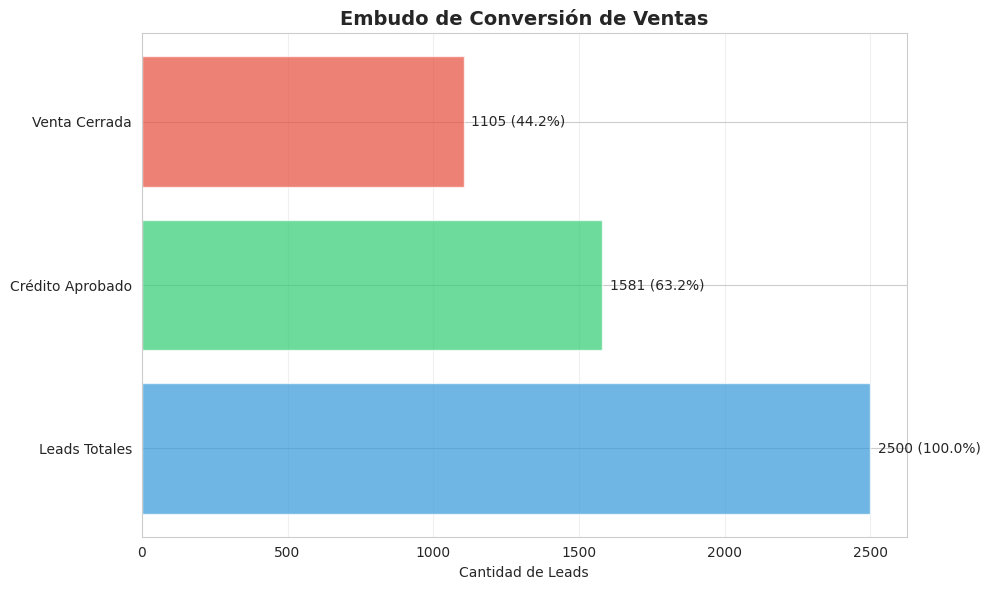

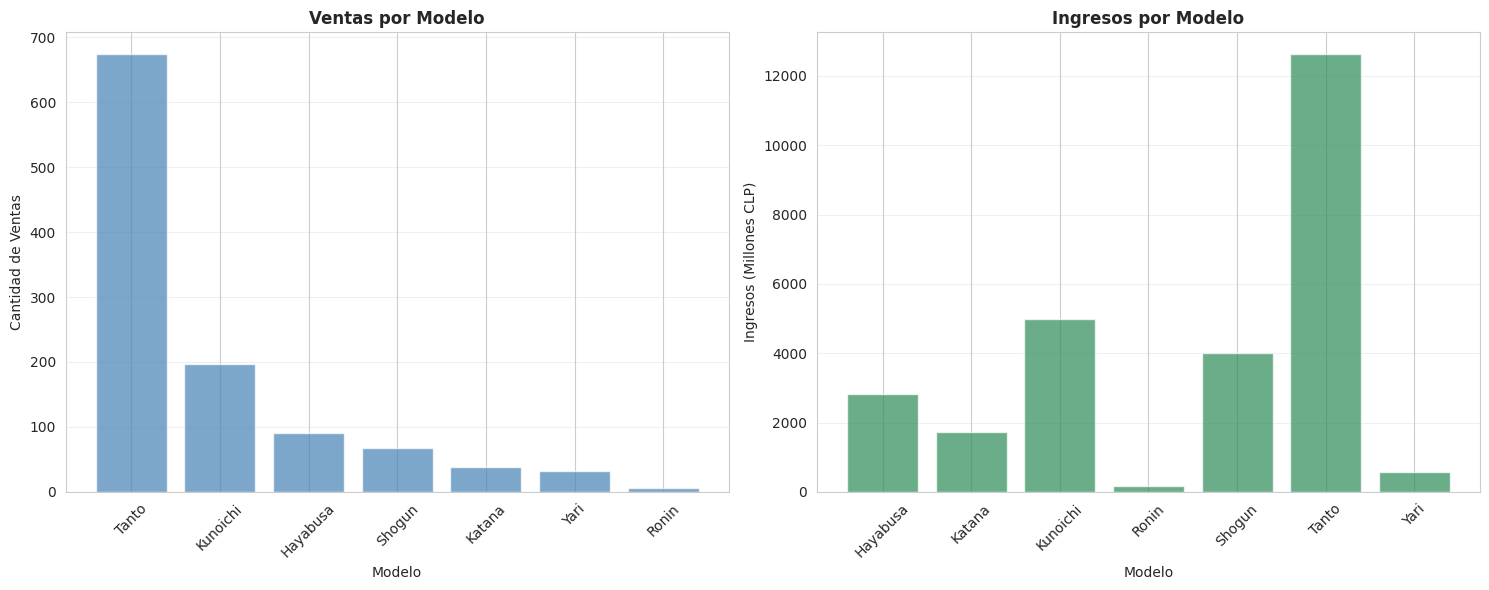

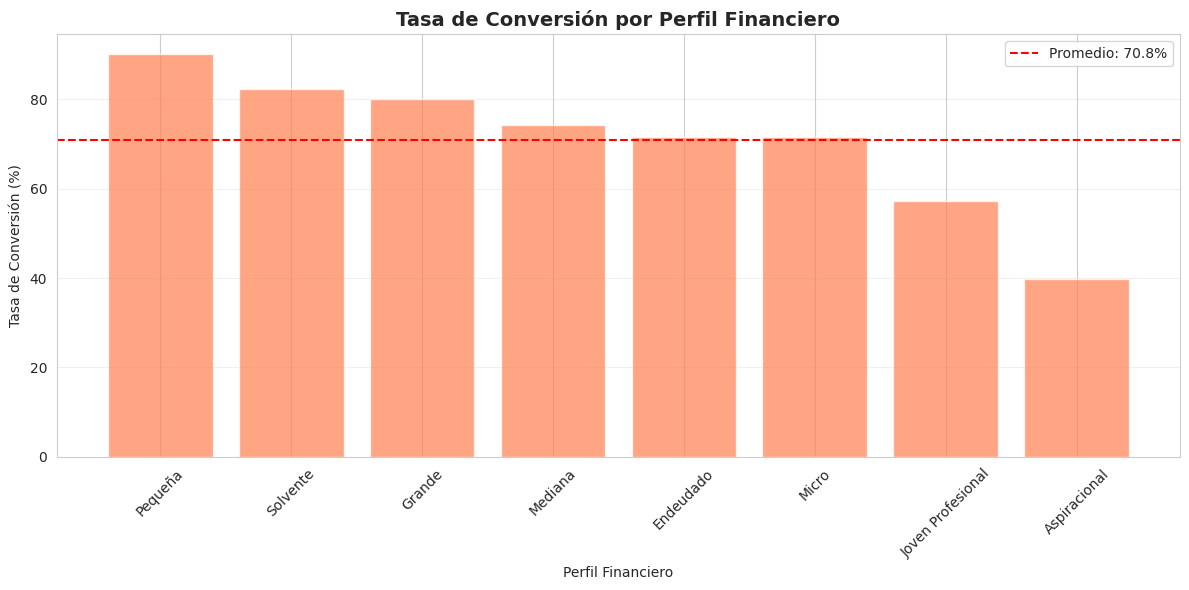

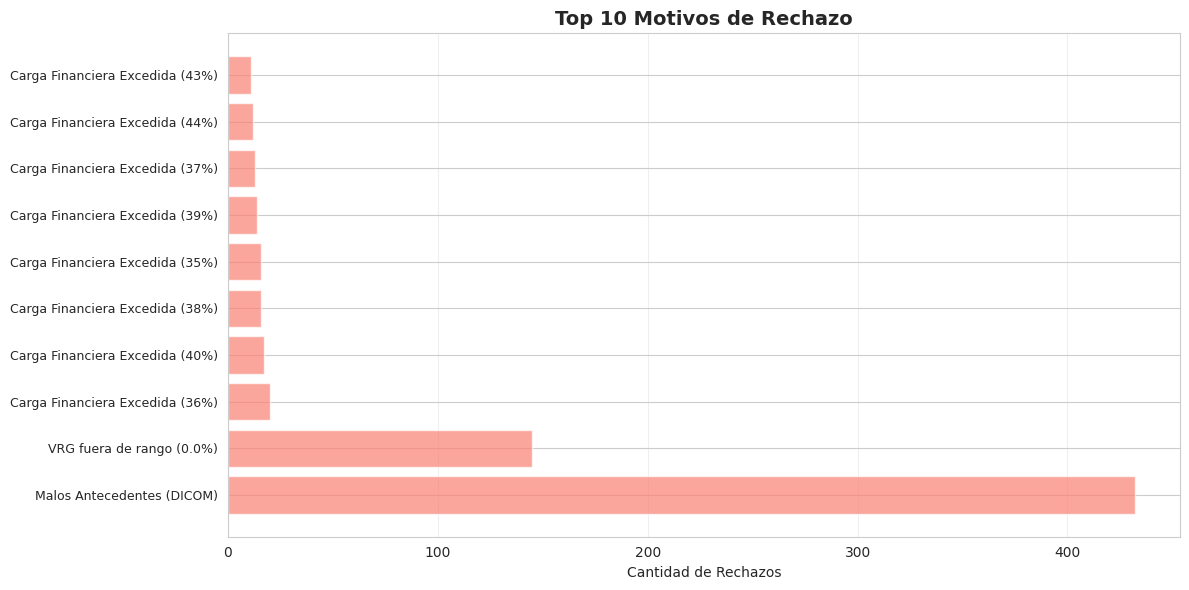

In [38]:
analisis_visual_completo(df_resultados_final)

### **Exportar resultados**

In [39]:
exportar_resultados_excel(df_resultados_final, nombre_archivo="simulacion_ventas.xlsx")

✓ Archivo exportado: simulacion_ventas.xlsx


'simulacion_ventas.xlsx'